/opt/homebrew/Caskroom/miniforge/base/envs/tif360/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using downloaded and verified file: ./pneumoniamnist_224.npz
Using downloaded and verified file: ./organamnist_224.npz
Using downloaded and verified file: ./dermamnist_224.npz


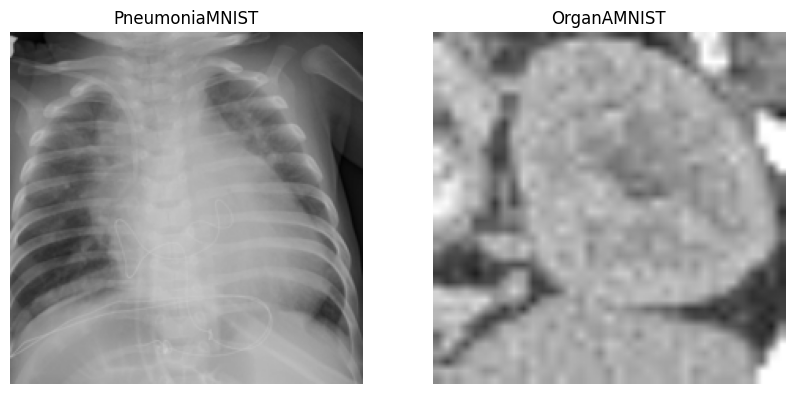

In [1]:
from medmnist import PneumoniaMNIST, OrganAMNIST, DermaMNIST, INFO
import matplotlib.pyplot as plt

# load dataset
pneumonia_data = PneumoniaMNIST(root='./', split='test', size=224,transform=None, download=True, as_rgb=True)
organ_data = OrganAMNIST(root='./', split='test', size=224,transform=None, download=True, as_rgb=True)
derma_data = DermaMNIST(root='./', split='test', size=224,transform=None, download=True, as_rgb=True)

# show images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(pneumonia_data[0][0])
plt.title('PneumoniaMNIST')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(organ_data[0][0])
plt.title('OrganAMNIST')
plt.axis('off')
plt.show()


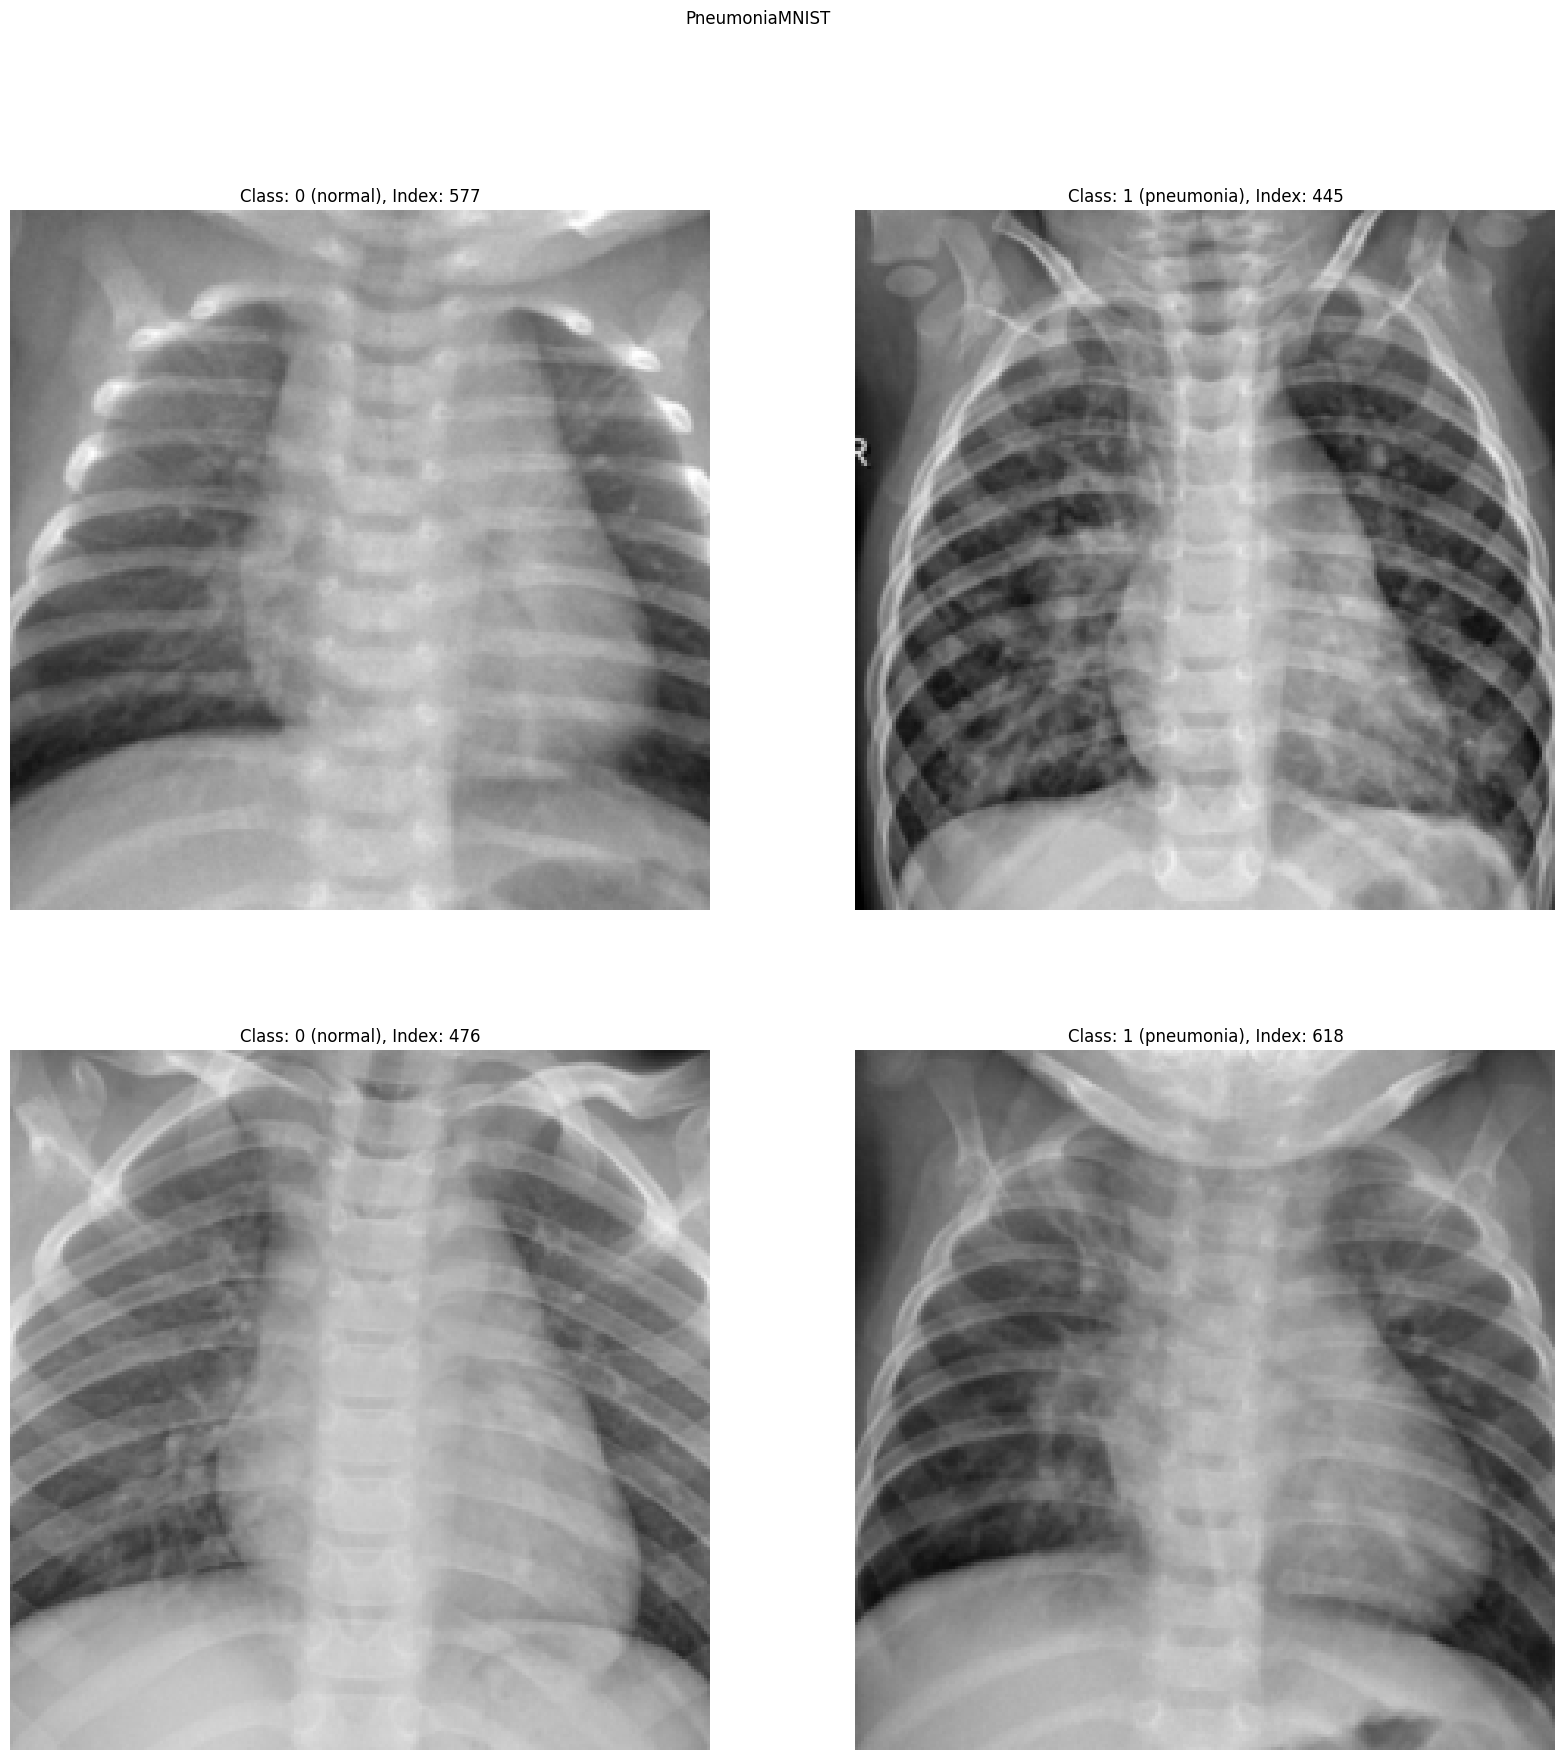

In [2]:
import numpy as np

def PlotFunction(data, title):
    fig, axs = plt.subplots(2, 2, figsize=(20, 20))
    labels = INFO[title.lower()]['label']
    fig.suptitle(title)

    imgIdx = np.random.randint(0, len(data), size=4)
    for i, idx in enumerate(imgIdx):
        axs[i//2, i%2].imshow(data[idx][0])
        axs[i//2, i%2].set_title(f'Class: {data[idx][1][0]} ({labels[str(data[idx][1][0])]}), Index: {idx}')
        axs[i//2, i%2].axis('off')

    plt.show()

PlotFunction(pneumonia_data, 'PneumoniaMNIST')

In [3]:
#INFO['organamnist']
labels = INFO['organamnist']['label']
print(labels)
print(labels['0'])

{'0': 'bladder', '1': 'femur-left', '2': 'femur-right', '3': 'heart', '4': 'kidney-left', '5': 'kidney-right', '6': 'liver', '7': 'lung-left', '8': 'lung-right', '9': 'pancreas', '10': 'spleen'}
bladder


### ViT

In [6]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda, Resize
from medmnist import INFO, TissueMNIST, PneumoniaMNIST, DermaMNIST, OrganAMNIST
from transformers import ViTForImageClassification
from transformers import AdamW

def load_data(data_flag='pneumoniamnist', batch_size=16):
    n_classes = len(INFO[data_flag]['label'])
    transform = Compose([
        Resize((224, 224)),
        ToTensor(),
        Lambda(lambda x: x.repeat(3, 1, 1)),
        Normalize(mean=[0.5]*3, std=[0.5]*3)
    ])

    train_dataset = PneumoniaMNIST(split='train', transform=transform, download=True)
    val_dataset = PneumoniaMNIST(split='val', transform=transform, download=True)
    test_dataset = PneumoniaMNIST(split='test', transform=transform, download=True)

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, n_classes, train_dataset, val_dataset, test_dataset

def setup_model(n_classes):
    model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=n_classes)
    return model

def train_and_evaluate(model, train_loader, val_loader, device):
    print(f'Using device: {device}')
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()

    best_accuracy = 0
    best_model_path = 'organA224.pth'

    model.train()
    for epoch in range(10):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.squeeze(1).long()

            outputs = model(images).logits
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        total, correct = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                labels = labels.squeeze(1).long()

                outputs = model(images).logits
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f'Epoch {epoch+1}, Loss: {loss.item()}, Validation Accuracy: {accuracy}%')

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model saved with accuracy: {accuracy}% at epoch {epoch+1}")

    print(f'Training complete. Best model was saved with an accuracy of {best_accuracy}%.')




def main():
    device = "mps" if torch.backends.mps.is_available() else "cpu"
    #device = "cuda" if torch.cuda.is_available() else "cpu"
    train_loader, val_loader, test_loader, n_classes, _, _, _ = load_data()
    model = setup_model(n_classes)
    train_and_evaluate(model, train_loader, val_loader, device)

def EvaluateModel(loader, model, device, label, data):
    model.to(device)

    model.eval()
    total, correct = 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.squeeze(1).long()
        outputs = model(images).logits
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        #print('Predicted: ', predicted)
        #print('Actual: ', labels)

    accuracy = 100 * correct / total
    print(f'{label} Accuracy: {accuracy:.2f}%')

if __name__ == '__main__':
    #main()
    pass

### Performance

In [8]:
train_loader, val_loader, test_loader, n_classes, train_dataset, val_dataset, test_dataset= load_data()
device = "mps" if torch.backends.mps.is_available() else "cpu"
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=n_classes, output_attentions=True, output_hidden_states=False)
model.load_state_dict(torch.load('project/ViT/pneumonia224.pth'))

EvaluateModel(train_loader, model, device, 'Training', train_dataset)
EvaluateModel(val_loader, model, device, 'Validation', val_dataset)
EvaluateModel(test_loader, model, device, 'Test', test_dataset)

Using downloaded and verified file: /Users/oscarrosman/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /Users/oscarrosman/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /Users/oscarrosman/.medmnist/pneumoniamnist.npz


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training Accuracy: 99.64%
Validation Accuracy: 97.71%
Test Accuracy: 87.66%


### Visualise attention

Using downloaded and verified file: /Users/oscarrosman/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /Users/oscarrosman/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /Users/oscarrosman/.medmnist/pneumoniamnist.npz


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using downloaded and verified file: ./pneumoniamnist_224.npz
Visualizing attention on PneumoniaMNIST dataset:
Minimum valid index: 0, Maximum valid index: 623
Index: 549, Length of dataset: 624


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Index: 288, Length of dataset: 624
Index: 208, Length of dataset: 624
Index: 266, Length of dataset: 624
Visualizing attention on OrganAMNIST dataset:
Minimum valid index: 0, Maximum valid index: 623


ValueError: Index 4854 is out of bounds for dataset OrganAMNIST

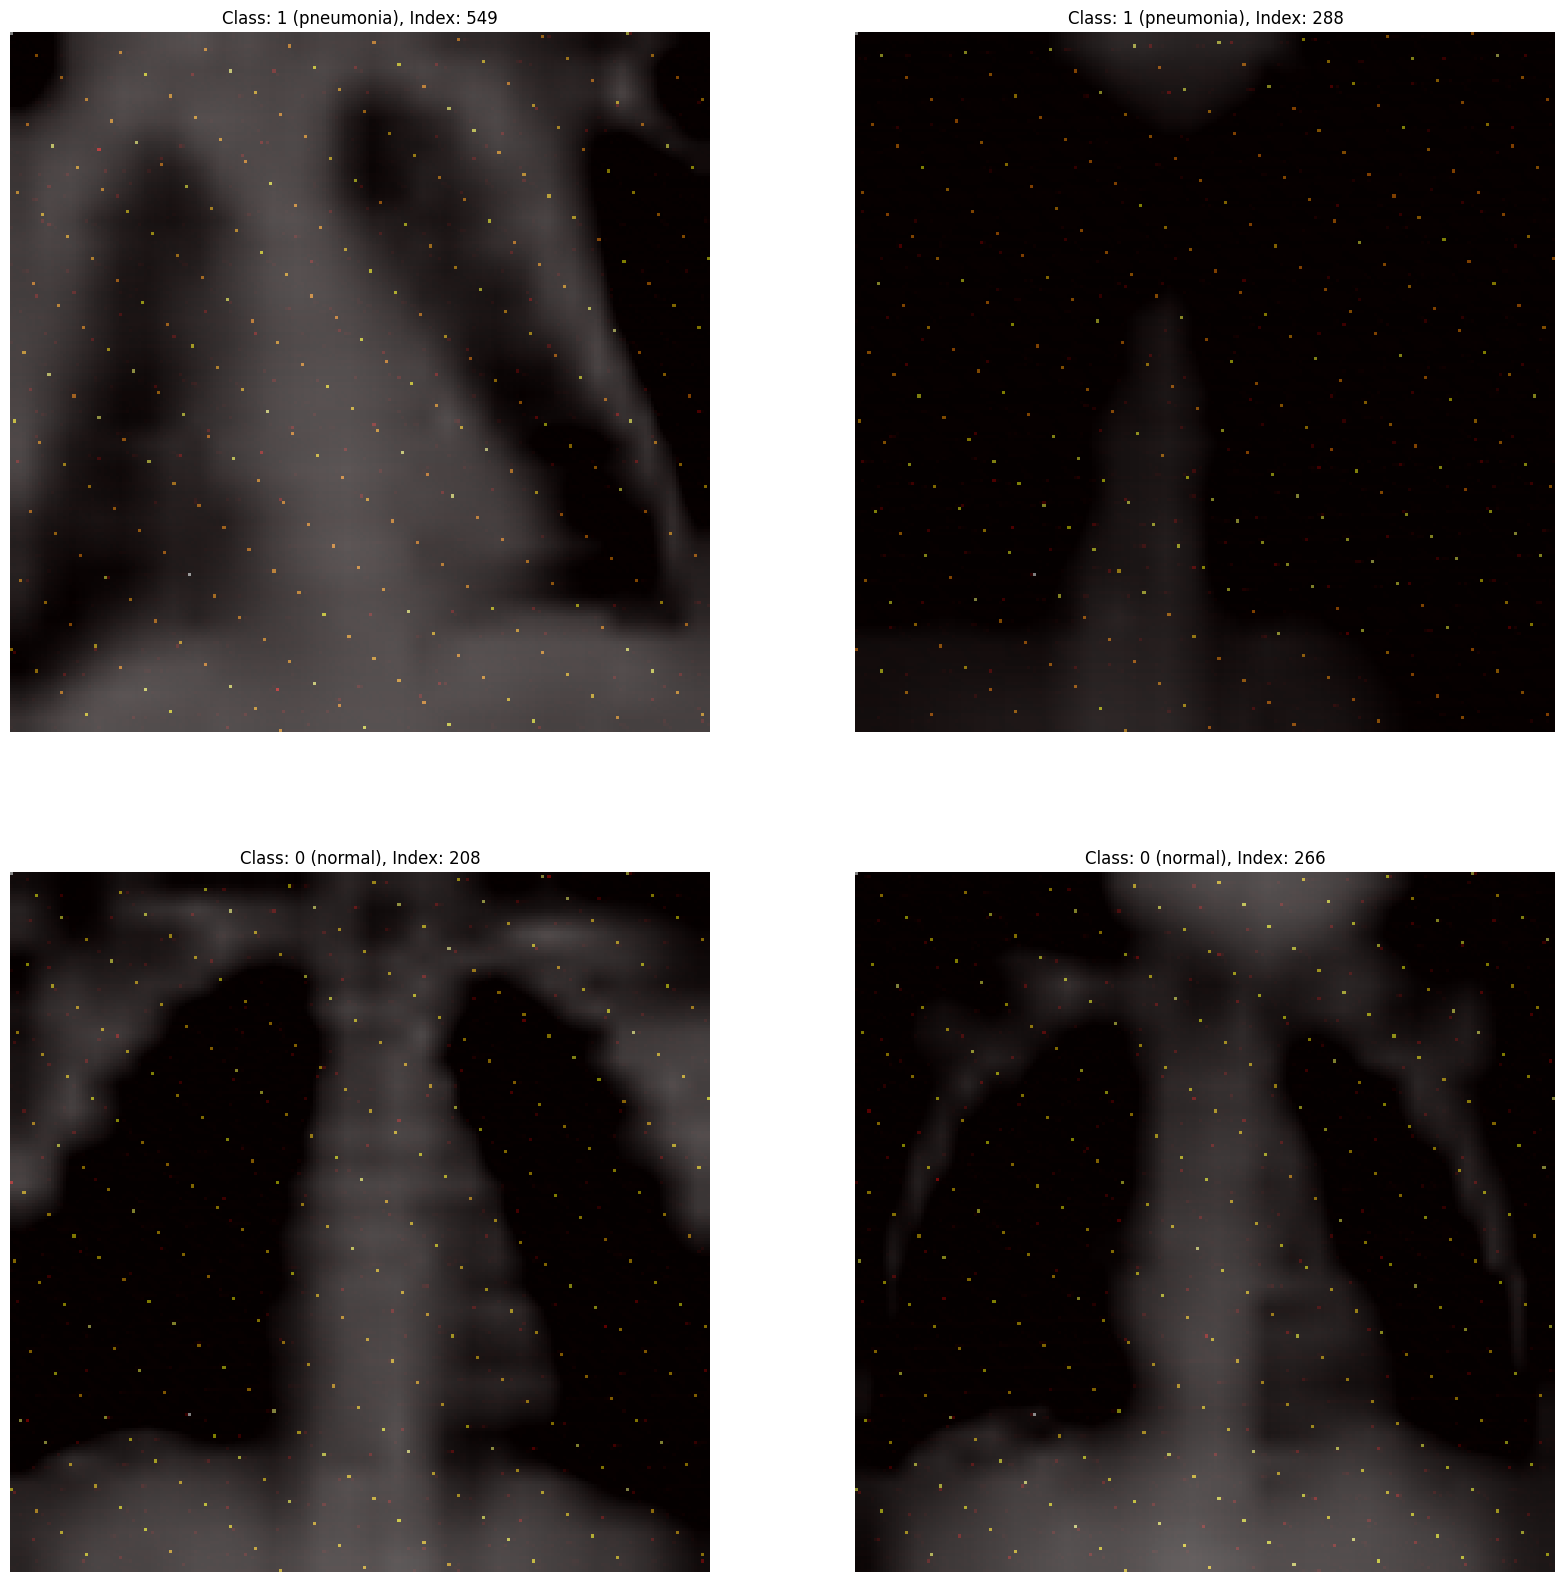

In [34]:
# Load data
train_loader, val_loader, test_loader, n_classes, train_dataset, val_dataset, test_dataset = load_data()

# Set device
device = "mps" if torch.backends.mps.is_available() else "cpu"

# Load pre-trained model
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=n_classes, output_attentions=True, output_hidden_states=True)
model.load_state_dict(torch.load('project/ViT/pneumonia224.pth'))
model.to(device)
title = 'PneumoniaMNIST' # 'OrganAMNIST'
labels = INFO[title.lower()]['label']
data = PneumoniaMNIST(root='./', split='test', size=224,transform=None, download=True, as_rgb=True)
#data = OrganAMNIST(root='./', split='test', size=224,transform=None, download=True, as_rgb=True)

def visualize_attention(model, image, label, ax):
    # Put model in evaluation mode
    model.eval()

    # Forward pass to get attention weights
    with torch.no_grad():
        outputs = model(image)
        prediction = outputs.logits.argmax(1)
        attention_weights = outputs.attentions  # Extract attention weights
        hidden_states = outputs.hidden_states  # Extract hidden states

    # Sum attention weights across batch and head dimensions
    att_head = attention_weights[0].sum(dim=0).sum(dim=0)
    att_head = att_head.cpu().numpy()

    # Normalize attention weights
    att_head = np.maximum(att_head, 0) / np.max(att_head)

    # Resize attention weights to match shape of input image
    att_head = np.resize(att_head, (224, 224))

    # Create heat map
    heatmap = plt.cm.hot(att_head)

    # Convert input image to RGB
    img_rgb = np.dstack((image.squeeze(0).permute(1, 2, 0).cpu().numpy(),) * 3)

    # Ensure that img_rgb has the correct shape
    img_rgb = img_rgb[:, :, :3]

    # Plot image with attention weights
    ax.imshow(img_rgb)
    ax.imshow(heatmap, alpha=0.5)
    ax.set_title(f'Class: {data[idx][1][0]} ({labels[str(data[idx][1][0])]}), Index: {idx}')
    ax.axis('off')


# Visualize attention on indexed images from pneumonia test set
imgIndicies = {'PneumoniaMNIST': [549, 288, 208, 266], 'OrganAMNIST': [4854, 7225, 7073, 14284]}
fig, axs = plt.subplots(2, 2, figsize=(20, 20))
counter = 0

# Create a ScalarMappable object for the color map
sm = plt.cm.ScalarMappable(cmap=plt.cm.hot)
sm.set_array([])  # Set empty array to avoid ValueError

for dataset_name, indices in imgIndicies.items():
    print(f'Visualizing attention on {dataset_name} dataset:')
    min_idx = 0
    max_idx = len(test_dataset) - 1
    print(f'Minimum valid index: {min_idx}, Maximum valid index: {max_idx}')
    for idx in indices:
        if idx < min_idx or idx > max_idx:
            raise ValueError(f'Index {idx} is out of bounds for dataset {dataset_name}')
        print(f'Index: {idx}, Length of dataset: {len(test_dataset)}')
        image, label = test_dataset[idx]
        image = image.unsqueeze(0).to(device)
        visualize_attention(model, image, label, axs[counter // 2, counter % 2])
        counter += 1

# Add color bar to the figure
cbar_ax = fig.add_axes([1.02, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_ylabel('Attention weight', rotation=-90, va="bottom")

# Adjust the spacing between subplots
fig.subplots_adjust(wspace=0.1, hspace=0.1)

plt.tight_layout()
plt.show()


